<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-1hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [96]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"
filename = "train-events-20-min.zip"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }
measurement = { 'unit' : 'minutes', 'size' : 60.0 }

In [97]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-events-20-min.zip...
-
Operation completed over 1 objects/40.7 MiB.                                     


In [98]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   21:33:57
2000   21:34:06
3000   21:34:16
4000   21:34:22
5000   21:34:27
6000   21:34:31


In [99]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [100]:
del trains

In [101]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6747 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            6747 non-null   object 
 1   positionHistoryList                                            6747 non-null   object 
 2   locomotiveList                                                 6747 non-null   object 
 3   subdivisionList                                                6747 non-null   object 
 4   trainEstimatedPositionList                                     6747 non-null   object 
 5   trainActualPositionList                                        6747 non-null   object 
 6   trainId.trainSCAC                                              6747 non-null   object 
 7   trainId.trainSection                                           

# Create a learning set to modify

In [102]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [103]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [104]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [105]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


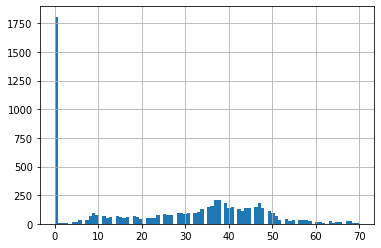

In [106]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [107]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [108]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [109]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['A' 'Q' 'M' 'H' 'G' 'U' 'I' 'O' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']
['TO_S_UP_MAINLINE' 'WEST MAIN' 'EAST MAIN' 'TO_N_EAST MAIN' 'MAIN' 'S_LUCAS' 'NEW LACY TRACK' 'MAIN CHAISON YARD' 'MT 2' 'MT 1' 'S_VIDOR' 'TO_S_VIDOR' 'TO_S_CS JUNCTION' 'S_HELME' 'EASTXO'
 'TO_S_KCS UP PRT CONN' 'KCS UP PORT CONNECT' 'WESTXO' 'N SIDING' 'XO' 'TO_N_HELME' 'TO_N_CHAISON MAIN' 'TO_N_LUCAS' 'TO_N_STARKS' 'S_STARKS' 'S_MAURICEVILLE' 'TO_S_LUCAS' 'TO_N_MAURICEVILLE' 'YD LD'
 'TO_N_VIDOR' 'S_FISHER' 'S_CONVERSE' 'S_ANACOCO' 'S_NEAME' 'S_LEESVILLE']
['UP']
['' '2' '3' '4' '5']
[1. 2. 0. 4. 3.]
[14. 12.  0.  9.  8. 10. 18. 15.  4. 20. 11.  2. 17. 16. 13. 19.]
[2. 0. 3. 1.]
[3. 0. 2.]
['AMTK' 'BNSF' 0.0 '' 'KCS']
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [110]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [111]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [112]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [113]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '225.10', '202.20,219.70', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '250.50,202.20', '258.40,202.20', '258.40,207.60,202.20', '321.50,202.20', '202.20,314.52',
       '202.20,214.50,225.10,290.80,304.10', '214.50,225.10,290.80,304.10,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '258.40,214.50,202.20', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [114]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [115]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [116]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])


You can peer into the incoming data here:

In [117]:
idx = 201
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

KCS4151
MRNWAJ


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-07-01T02:21:09Z,0,106,WEST MAIN,766.24380
1,2022-07-01T02:23:09Z,0,106,WEST MAIN,766.24380
2,2022-07-01T02:25:09Z,-1,106,WEST MAIN-MAIN,766.19920
3,2022-07-01T02:27:09Z,-5,106,WEST MAIN-MAIN,766.11084
4,2022-07-01T02:29:09Z,-9,106,MAIN,765.94490
...,...,...,...,...,...
16,2022-07-01T02:53:09Z,-8,106,S_VIDOR,761.16580
17,2022-07-01T02:55:09Z,-7,106,S_VIDOR,760.92035
18,2022-07-01T02:57:09Z,-6,106,S_VIDOR,760.67960
19,2022-07-01T02:59:09Z,-4,106,S_VIDOR,760.45135


In [118]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.8706,[]
0,766.9310,[]
0,764.8691,[]
0,766.9302,[]
...,...,...
0,290.7408,"[{'positionTime': '2022-06-23T10:15:47Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 290.7408}}}, {'positionTime': '2022-06-23T10:17:47Z', 'speedMPH': 30, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 291.4418}}}, {'positionTime': '2022-06-23T10:19:47Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 292.6651}}}, {'positionTime': '2022-06-23T10:21:47Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId':..."
0,293.2164,[]
0,294.0817,"[{'positionTime': '2022-06-23T11:17:23Z', 'speedMPH': 23, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 294.0817}}}, {'positionTime': '2022-06-23T11:19:23Z', 'speedMPH': 35, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 295.03876}}}, {'positionTime': '2022-06-23T11:21:23Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 296.39496}}}, {'positionTime': '2022-06-23T11:23:23Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106..."
0,305.3550,"[{'positionTime': '2022-06-23T11:34:06Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 305.355}}}, {'positionTime': '2022-06-23T11:36:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 307.01364}}}, {'positionTime': '2022-06-23T11:38:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 308.68835}}}, {'positionTime': '2022-06-23T11:40:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


Renumber the list

In [119]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextMilepost
This will be the value we are attempting to learn

In [120]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [121]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [122]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [123]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print(nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print(nextActual)

nextSpeed = findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print("actual speed: ",nextSpeed)
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop speed: ")
  value = findNextSpeed(dfTrainsLearn.iloc[idx], beopDT)
  print(value)

UP6579
CNAPW9
Reported speed:  42
Reported MP:  315.8773
Reported Time:  2022-06-26T02:15:16Z
           positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-26T02:17:16Z       -43                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 314.40375  
8
actual speed:  -10
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-26T02:17:16Z       -44                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                  314.4466  
beop speed: 
8


Run the calulations.  This will take a moment.

In [124]:
dfTrainsLearn['nextSpeed'] = np.NaN
dfTrainsLearn['nextBeop'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextSpeed = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'nextBeop'] = nextSpeed
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000


In [125]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextSpeed'])
dfTrainsLearn['nextSpeed'].unique()

array([ -8., -28.,   0.,  40.,  36.,  43.,  13.,  -3., -12.,  19.,  20.,   3.,   2.,   1.,  14., -14., -23., -30., -47., -27.,  29.,  37.,  44., -41., -44., -36., -34.,   4.,  -2.,  -1.,  -5.,  15.,
        10.,  28., -18., -11.,   9.,  -9.,  17., -16., -15.,  38.,  -4.,   5.,   6.,  18.,  -7., -10., -17.,   7.,   8.,  12., -19., -31.,  35., -39.,  11.,  32.,  34., -37., -26.,  33., -38., -35.,
        24., -22., -49.,  -6.,  47., -40.,  23.,  16.,  22., -42., -29., -21., -61.,  31., -32.,  48.,  27.,  41., -25., -45.,  46.,  21.,  25., -55.,  57.,  39., -46.,  26.,  30., -20.,  56., -13.,
       -53., -68., -70.,  55.,  60., -59., -51., -56.,  50.,  53., -24., -33., -50.,  42., -48., -57.,  58.,  49.,  45.,  67., -43., -52.,  51.,  54.,  63.,  52., -54.,  64.,  62.])

NextSpeed values histogram:


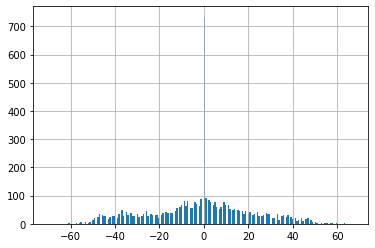

In [126]:
print("NextSpeed values histogram:")
dfTrainsLearn['nextSpeed'].hist(bins=200)

In [127]:
dfTrainsLearn['nextBeop'].unique()

array([ -8., -28.,  nan,  20.,   3.,   2.,  13.,   0.,   1.,  14., -14.,  -3., -23., -30., -47., -27.,  29., -41., -44., -36., -34.,   4.,  -2.,  -1.,  -5.,  15.,  28., -18., -16., -12., -15.,  -4.,
        38., -10., -31.,  -9., -11., -39.,  34., -37., -26., -38., -35.,  24., -22., -49.,  -6., -19., -40., -17.,  23.,  16.,   7.,  22., -42.,   5.,  32.,  10.,   9.,  17., -29.,  18.,   8., -21.,
       -61.,  -7., -32.,  11.,  27.,  12., -25., -45.,  21.,  25., -55., -46., -20.,  41.,  19.,  33., -13., -53., -68., -70., -59., -51., -56.,   6.,  30.,  31., -24., -33.,  40., -50.,  26., -48.,
       -57.,  36.,  46.,  37.,  49.,  67.,  35., -43., -52.,  54.,  43., -54.,  50.,  39.])

physics predictions histogram:


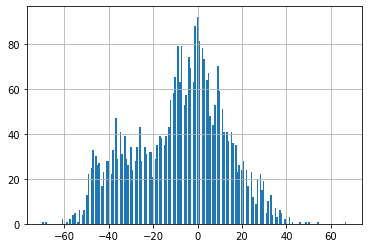

In [128]:
print("physics predictions histogram:")
dfTrainsLearn['nextBeop'].hist(bins=200)

In [129]:
dfTrainsNextBeop = dfTrainsLearn['nextBeop']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [130]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'nextBeop',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [131]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
34,BNSF5833,UP,,MNOEW,...,False,False,False,1.655754e+09
35,BNSF5833,UP,,MNOEW,...,False,False,False,1.655755e+09
36,BNSF5833,UP,,MNOEW,...,False,False,False,1.655756e+09
37,BNSF5833,UP,,MNOEW,...,False,False,False,1.655757e+09
38,BNSF5833,UP,,MNOEW,...,False,False,False,1.655758e+09
...,...,...,...,...,...,...,...,...,...
6738,UP9101,UP,,MCHCB,...,False,False,False,1.655975e+09
6739,UP9101,UP,,MCHCB,...,False,False,False,1.655976e+09
6740,UP9101,UP,,MCHCB,...,False,False,False,1.655977e+09
6741,UP9101,UP,,MCHCB,...,False,False,False,1.655978e+09


In [132]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(4705, 47)
(6747,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4705 entries, 34 to 6742
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            4705 non-null   object        
 1   trainId.trainSCAC                                              4705 non-null   category      
 2   trainId.trainSection                                           4705 non-null   category      
 3   trainId.trainSymbol                                            4705 non-null   object        
 4   trainId.trainDate                                              4705 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  4705 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            4705 non-null

# Use Decision Tree to predict next speed

In [133]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [134]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
171    355
172    355
173    427
174    578
175    456
176    419
177    436
178    403
179    399
180    393
181    406
182     78
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [135]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * .66)])

We will partition this set at day of year: 178


In [136]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * .66)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [137]:
dep_var = 'nextSpeed'

In [138]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [139]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [140]:
len(to.train),len(to.valid)

(3429, 1276)

In [141]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
34,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,8,720.410889,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,720,1,6,25,20,0,171,1.655754e+09,-8.0
35,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,28,724.460693,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,724,1,6,25,20,0,171,1.655755e+09,-28.0
36,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696106,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655756e+09,0.0
37,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696411,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655757e+09,0.0
38,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697998,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655758e+09,0.0
39,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697388,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655759e+09,0.0
40,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655761e+09,0.0
41,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655762e+09,0.0
42,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696777,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655763e+09,0.0
43,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,7

In [142]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [143]:
to = fastai.load_pickle('/tmp/to.pkl')

In [144]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [145]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

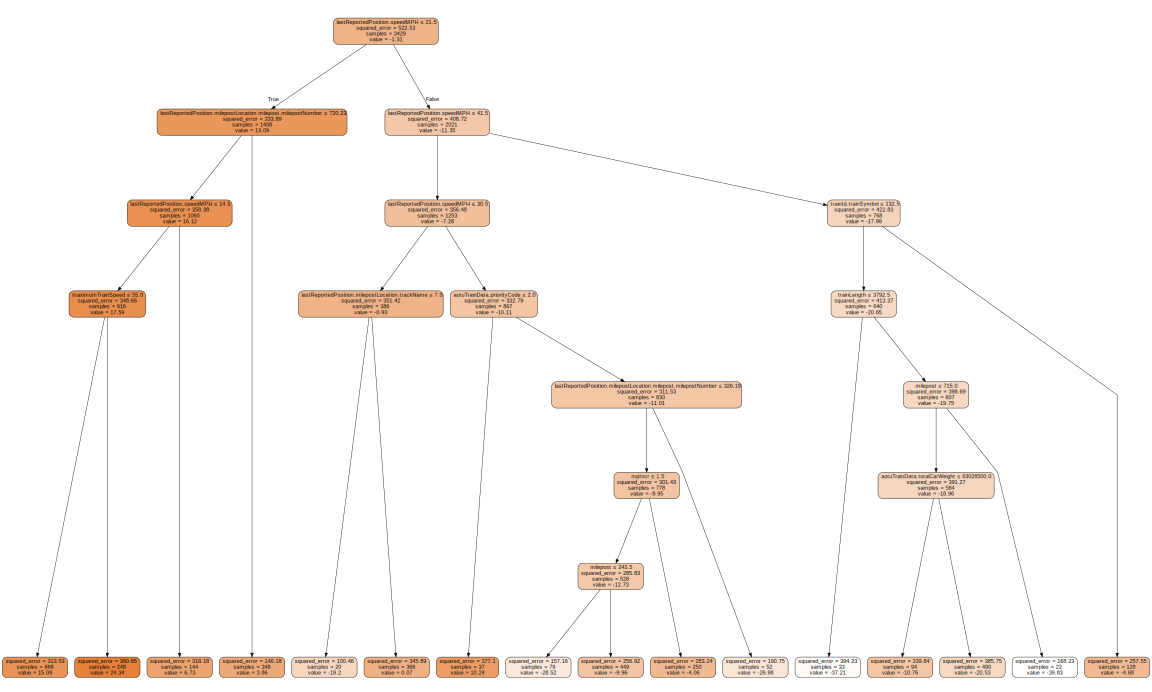

In [146]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [147]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

In [148]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the traing model:

In [149]:
m_rmse(m, xs, y)

12.588724

How well we fit the Validation Model:

In [150]:
m_rmse(m, valid_xs, valid_y)

18.831894

In [151]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [152]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
22,lastReportedPosition.speedMPH,0.492915
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.147677
3,trainId.trainSymbol,0.052933
45,lastReportedPosition.positionTimeElapsed,0.047554
0,ptcLeadLocomotiveId,0.029275
26,aotuTrainData.totalLocomotiveWeight,0.025616
12,mpIncr,0.020323
33,maximumTrainSpeed,0.018889
37,trailingTonnage,0.018132
25,aotuTrainData.totalCarLength,0.017772


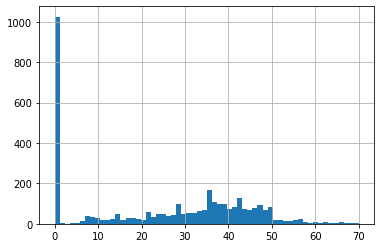

In [153]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


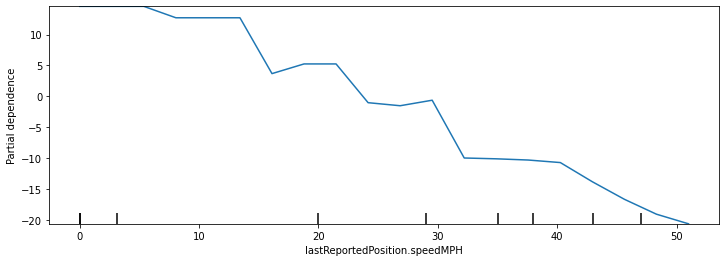

In [154]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [155]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [156]:
m = randomForest(xs, y);

In [157]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(11.829238, 15.616416)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [159]:
r_mse(preds.mean(0), valid_y)

15.616416

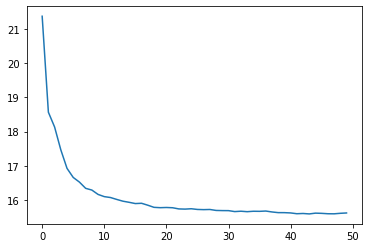

In [160]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [ ]:
r_mse(m.oob_prediction_, y)

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [163]:
preds.shape

(50, 1276)

In [164]:
preds_std = preds.std(0)

In [165]:
preds_std[:5]

array([14.42479556, 14.12437227, 12.46199303, 13.59138138, 14.08589726])

In [166]:
print(preds.mean(0)[:10])
print(valid_y[:10])

[  7.85982739  17.3112177   24.26214189 -12.43224459 -13.59361211  -6.56427078 -16.22739721 -14.50710945   8.82876127 -12.92320685]
55     -3.0
98     20.0
99     36.0
100     3.0
101     2.0
102    13.0
103     0.0
104     1.0
105    14.0
106   -14.0
Name: nextSpeed, dtype: float32


# FEATURE Importance

In [167]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
22,lastReportedPosition.speedMPH,0.418978
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.105740
38,milepost,0.062306
12,mpIncr,0.055685
45,lastReportedPosition.positionTimeElapsed,0.043551
3,trainId.trainSymbol,0.035707
36,trainLength,0.025190
0,ptcLeadLocomotiveId,0.022850
26,aotuTrainData.totalLocomotiveWeight,0.020298
24,aotuTrainData.totalCarWeight,0.020102


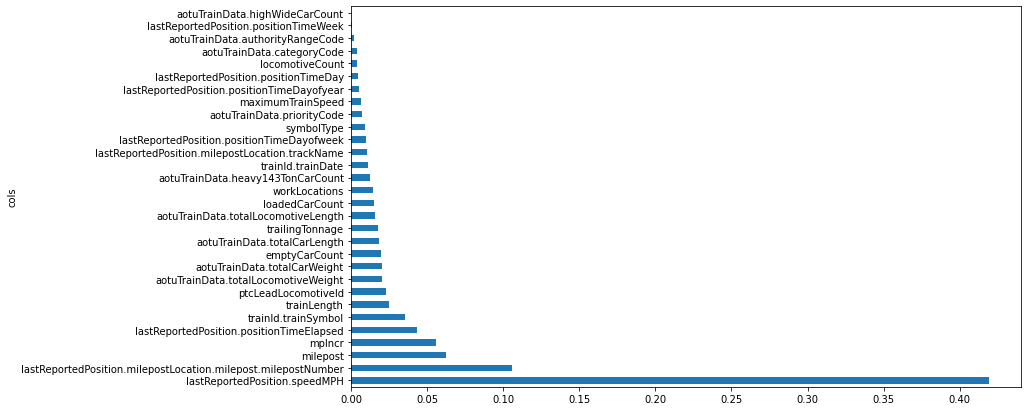

In [168]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [169]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

27

In [170]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [171]:
m = randomForest(xs_imp, y)

In [172]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(11.769467, 15.60093)

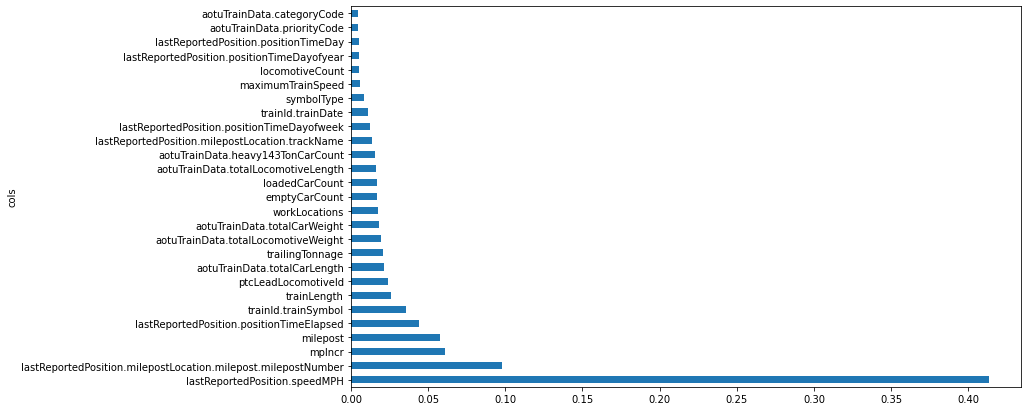

In [173]:
plot_fi(rf_feat_importance(m, xs_imp));

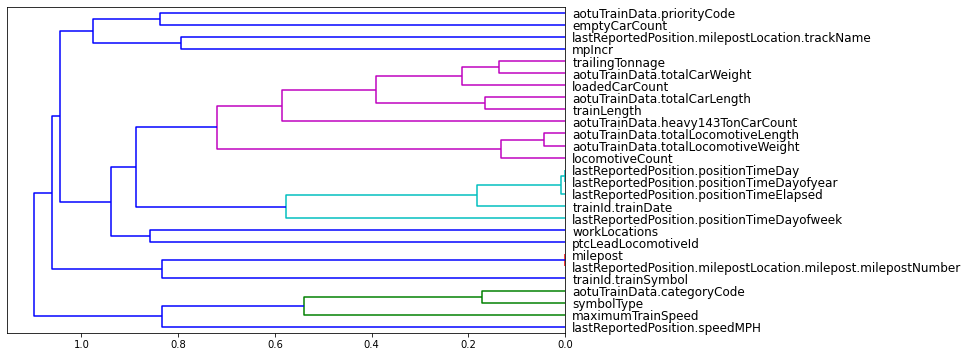

In [174]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [175]:
b = dfTrainsNextBeop.tail(14165)
# beopValues = beopValues.to_frame().join(valid_y)
#m_rmse(m, valid_xs_imp, valid_y)
b = b.reset_index(drop=true)
#print (b)
y = valid_y.reset_index(drop=true)
#print (y)
df2  = pd.concat([b, y], axis=1)
df2.dropna()
print(df2)
r_mse(df2['nextBeop'], df2['nextSpeed'])
# print(BeopValidations[:5])
#print(valid_y[:5])

      nextBeop  nextSpeed
0         -8.0       -3.0
1        -28.0       20.0
2          NaN       36.0
3          NaN        3.0
4          NaN        2.0
...        ...        ...
4700     -16.0        NaN
4701     -35.0        NaN
4702     -46.0        NaN
4703     -47.0        NaN
4704      13.0        NaN

[4705 rows x 2 columns]


30.132426

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [176]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.418476
45,lastReportedPosition.positionTimeElapsed,0.259924
42,lastReportedPosition.positionTimeDay,0.257759
41,lastReportedPosition.positionTimeWeek,0.039731
4,trainId.trainDate,0.010062
43,lastReportedPosition.positionTimeDayofweek,0.006660
17,lastReportedPosition.positionTimeIs_month_start,0.003845
19,lastReportedPosition.positionTimeIs_quarter_start,0.002100


Consider whether these values make sense

#Using a Neural Net

In [177]:
df_nn_final = dfTrainsLearn

In [178]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4705 entries, 34 to 6742
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            4705 non-null   object        
 1   trainId.trainSCAC                                              4705 non-null   category      
 2   trainId.trainSection                                           4705 non-null   category      
 3   trainId.trainSymbol                                            4705 non-null   object        
 4   trainId.trainDate                                              4705 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  4705 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            4705 non-null   int64         
 

In [179]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [180]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [181]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    382
trainId.trainSCAC                                        1
trainId.trainSection                                     4
trainId.trainSymbol                                    139
trainId.trainDate                                       19
lastReportedPosition.speedMPH                           70
lastReportedPosition.milepostLocation.subdivisionId      1
lastReportedPosition.milepostLocation.trackName         32
aotuTrainData.priorityCode                               5
aotuTrainData.categoryCode                              11
aotuTrainData.authorityRangeCode                         4
aotuTrainData.ownershipCode                              3
aotuTrainData.eventCode                                  1
milepost                                               217
mpIncr                                                   2
symbolType                                              12
workLocations                                           

In [182]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [183]:
dls = to_nn.dataloaders(1024)

In [184]:
y = to_nn.train.y
y.min(),y.max()

(-70.0, 67.0)

In [185]:
learn = tabular_learner(dls, y_range=(-70,70), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003311311302240938)

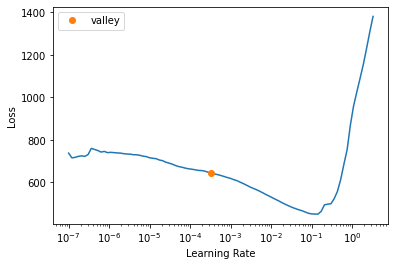

In [186]:
learn.lr_find()

In [187]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,time
0,752.372009,468.928772,00:00
1,701.531189,467.459991,00:00
2,654.122192,470.943878,00:00
3,611.742065,468.144531,00:00
4,566.149841,453.742065,00:00
5,516.154236,448.742462,00:00
6,475.251099,391.131226,00:00
7,440.088440,383.262360,00:00
8,409.026794,353.759949,00:00
9,382.553955,334.188049,00:00


In [188]:
preds,targs = learn.get_preds()
print(r_mse(preds,targs))
print(preds[:10])
print(targs[:10])

22.592736
tensor([[  2.1466],
        [ 22.3122],
        [ 23.1704],
        [-22.5098],
        [-10.0358],
        [ -8.0694],
        [ -5.4238],
        [-17.8871],
        [ 24.9830],
        [  5.4893]])
tensor([[ -3.],
        [ 20.],
        [ 36.],
        [  3.],
        [  2.],
        [ 13.],
        [  0.],
        [  1.],
        [ 14.],
        [-14.]])
